In [19]:
import pandas as pd

# Cargar los datos
file_path = "fintech_credit_approval.csv"
df = pd.read_csv(file_path)

# Mostrar una vista previa de los datos
df.head()

,user_id,age,monthly_income_usd,app_usage_score,digital_profile_strength,num_contacts_uploaded,residence_risk_zone,political_event_last_month,approved
0,U00001,45,578.22,2.65,57.41,46,media,1,0
1,U00002,49,974.31,2.71,37.69,48,media,1,0
2,U00003,53,814.68,3.62,9.45,37,media,0,0
3,U00004,62,1178.71,9.26,47.46,46,baja,0,1
4,U00005,57,1140.57,2.19,70.99,38,alta,0,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     1000 non-null   object 
 1   age                         1000 non-null   int64  
 2   monthly_income_usd          1000 non-null   float64
 3   app_usage_score             1000 non-null   float64
 4   digital_profile_strength    1000 non-null   float64
 5   num_contacts_uploaded       1000 non-null   int64  
 6   residence_risk_zone         1000 non-null   object 
 7   political_event_last_month  1000 non-null   int64  
 8   approved                    1000 non-null   int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 70.4+ KB


In [21]:
# Resumen estadístico de las variables numéricas
resumen_numerico = df.describe()

# Conteo de valores nulos por columna
valores_nulos = df.isnull().sum()

resumen_numerico, valores_nulos


(               age  monthly_income_usd  app_usage_score  \
 count  1000.000000         1000.000000      1000.000000   
 mean     40.979000          894.504840         4.928240   
 std      13.461938          308.273355         2.882965   
 min      18.000000          -39.990000         0.010000   
 25%      30.000000          685.732500         2.477500   
 50%      42.000000          909.170000         4.780000   
 75%      52.250000         1112.110000         7.492500   
 max      64.000000         1726.660000        10.000000   
 
        digital_profile_strength  num_contacts_uploaded  \
 count               1000.000000            1000.000000   
 mean                  60.195220              40.002000   
 std                   19.633791               6.435947   
 min                    5.910000              21.000000   
 25%                   47.337500              36.000000   
 50%                   59.730000              40.000000   
 75%                   73.590000             

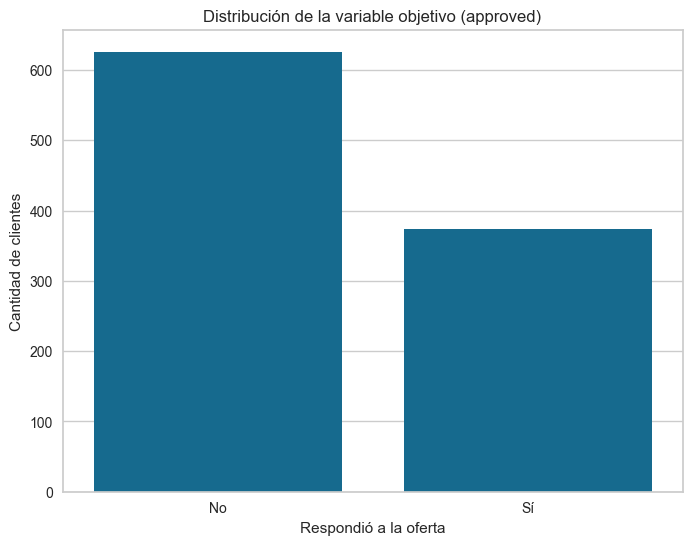

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aumentar el tamaño de los gráficos
plt.rcParams["figure.figsize"] = (8, 6)

# Distribución de la variable objetivo
sns.countplot(data=df, x="approved")
plt.title("Distribución de la variable objetivo (approved)")
plt.xlabel("Respondió a la oferta")
plt.ylabel("Cantidad de clientes")
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

In [23]:
# Convertir la columna 'political_event_last_month' a tipo categoría
df['political_event_last_month'] = df['political_event_last_month'].astype('category')

In [24]:

def winsorize_iqr(df, column):
    """
    Reemplaza los outliers en una columna de un DataFrame usando el método IQR.
    Los valores menores que el límite inferior se reemplazan por ese límite,
    y lo mismo para los superiores.

    Parámetros:
        df (pd.DataFrame): El DataFrame original.
        column (str): El nombre de la columna a tratar.

    Retorna:
        pd.Series: La columna modificada con winsorización aplicada.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Aplicar winsorización
    winsorized = df[column].copy()
    winsorized[winsorized < lower_bound] = lower_bound
    winsorized[winsorized > upper_bound] = upper_bound

    return winsorized


In [25]:
df['monthly_income_usd'] = winsorize_iqr(df, 'monthly_income_usd') # ya que habian negativos y valores muy bajos


In [26]:
import pandas as pd
from pycaret.classification import *

In [27]:
#1. Setup(): Definir el dataset y parámetros
# Configuración mejorada de setup() para un dataset desbalanceado
cls = setup(
    data=df,                       # dataframe con los datos
    target='approved',               # columna objetivo (clase)
    session_id=123,                 # para reproducibilidad
    normalize=True,                 # normaliza variables numéricas
    ignore_features=['user_id'],
    categorical_features=['residence_risk_zone', 'political_event_last_month'],  # columnas categóricas
    numeric_imputation='mean',      # reemplazo de valores faltantes numéricos
    categorical_imputation='mode',  # reemplazo de valores faltantes categóricos
    fix_imbalance=True,             # habilita técnicas de rebalanceo de clase
    fix_imbalance_method='SMOTE',   # método para generar muestras de la clase minoritaria
    fold_strategy='stratifiedkfold' # mantiene la proporción de clases en folds de validación
)

,Description,Value
0,Session id,123
1,Target,approved
2,Target type,Binary
3,Original data shape,"(1000, 9)"
4,Transformed data shape,"(1176, 10)"
5,Transformed train set shape,"(876, 10)"
6,Transformed test set shape,"(300, 10)"
7,Ignore features,1
8,Numeric features,5
9,Categorical features,2


In [28]:
#2. Compare_models(): Comparar multiples modelos y los rankear
best_model = compare_models(sort='AUC')
best_model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9857,0.9998,0.9809,0.9819,0.9810,0.9696,0.9700,0.1380
rf,Random Forest Classifier,0.9771,0.9990,0.9506,0.9879,0.9684,0.9506,0.9515,0.1110
ada,Ada Boost Classifier,0.9957,0.9988,0.9962,0.9927,0.9943,0.9909,0.9910,0.0800
gbc,Gradient Boosting Classifier,0.9729,0.9982,0.9467,0.9814,0.9628,0.9414,0.9430,0.1150
et,Extra Trees Classifier,0.9400,0.9857,0.9084,0.9335,0.9187,0.8712,0.8737,0.1040
dt,Decision Tree Classifier,0.9814,0.9806,0.9772,0.9743,0.9753,0.9604,0.9610,0.0580
lr,Logistic Regression,0.8643,0.9429,0.8587,0.7987,0.8235,0.7138,0.7202,1.2560
ridge,Ridge Classifier,0.8543,0.9426,0.8929,0.7632,0.8204,0.6993,0.7092,0.0500
lda,Linear Discriminant Analysis,0.8543,0.9426,0.8929,0.7632,0.8204,0.6993,0.7092,0.0420
knn,K Neighbors Classifier,0.8443,0.9282,0.8474,0.7663,0.8024,0.6747,0.6802,0.0510


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

Ada Boost Classifier	0.9957	0.9988	0.9962	0.9927	0.9943	0.9909	0.9910

In [29]:
#4. Tune_model(): Ajuste automático de hiperparámetros
tuned_best_model = tune_model(best_model,optimize='F1')
tuned_best_model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9857,1.0000,0.9615,1.0000,0.9804,0.9692,0.9696
1,0.9857,0.9983,1.0000,0.9630,0.9811,0.9696,0.9701
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9857,1.0000,1.0000,0.9643,0.9818,0.9701,0.9705


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


LGBMClassifier(bagging_fraction=0.6, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=41, min_child_weight=0.001, min_split_gain=0.9,
               n_estimators=260, n_jobs=-1, num_leaves=70, objective=None,
               random_state=123, reg_alpha=2, reg_lambda=3, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

Ada Boost Classifier	0.9957	0.9991	0.9962	0.9927	0.9943	0.9909	0.9910

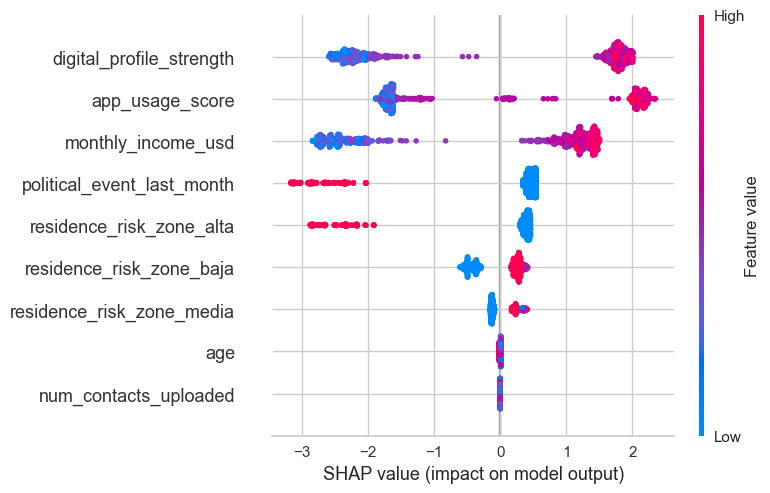

In [30]:
import shap
# 🧠 Interpretar con SHAP manualmente
X_train_transformed = get_config('X_train_transformed')
explainer = shap.TreeExplainer(tuned_best_model)
shap_values = explainer.shap_values(X_train_transformed)

# Detectar si shap_values es una lista (por clase) o una matriz única
if isinstance(shap_values, list):
    # Modelo binario: usar la matriz de la clase positiva
    shap_matrix = shap_values[1]
else:
    # Modelo binario con una sola matriz
    shap_matrix = shap_values

# Ajustar si hay columna extra (offset)
if shap_matrix.shape[1] == X_train_transformed.shape[1] + 1:
    shap_values_fixed = shap_matrix[:, :-1]
else:
    shap_values_fixed = shap_matrix

# Alinear filas si hay desajuste
min_rows = min(shap_values_fixed.shape[0], X_train_transformed.shape[0])
shap.summary_plot(shap_values_fixed[:min_rows], X_train_transformed.iloc[:min_rows])


In [31]:
plt.figure()
shap.summary_plot(shap_values_fixed[:min_rows], X_train_transformed.iloc[:min_rows], show=False)
plt.tight_layout()
plt.savefig("shap_summary.png", bbox_inches='tight')  # Guardar imagen
plt.close()